In [1]:
# Math libraries
import numpy as np
import scipy.linalg as lg

# For reading netcdf files
import xarray as xr
# Gets EOFs
from eofs.xarray import Eof

# Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%config InlineBackend.figure_format='retina'

# LIM Overview
We start with a system where we linearize the dynamics, and capture the non-linear dynamics in a stochastic forcing term:
$$
\frac{d\vec{x}}{dt} = \textbf{L}\vec{x} + \vec{\xi}
$$
where $\vec{x}$ is our state vector, $\textbf{L}$ is the "system matrix", and $\vec{\xi}$ is the stochastic forcing. The state vector is described by the empirical orthogonal functions, or EOFs. These functions are the eigenvectors of the covariance matrix $\Gamma$, and the time series are call the principal components, or PCs. Once we have the data in PC form, we want to calculate the system matrix. The most likely state vector at some future time $\tau_0$, is the integrated solution to the above eq. without the forcing:
$$
\vec{x}(t + \tau_0) = \textbf{G}(\tau)\vec{x}(t)
$$
where
$$
\textbf{G}(\tau_0) = \exp\left(\textbf{L}\tau_0 \right)
$$
Essentially, $\textbf{G}(\tau_0)$ acts to map the current state vector $\vec{x}(t)$ to a future state vector, $\vec{x}(t + \tau_0)$. We therefore want to minize the error function
$$
F = \left<|\vec{x}(t+\tau_0) - \textbf{G}(\tau_0)\vec{x}(t)|^2 \right>
$$
Later, we will see that we can find an expression for $\textbf{G}$ and then calculate $\textbf{L} = \tau_0^{-1}\ln \textbf{G}(\tau_0)$.

In [2]:
# Opening data
dataset = xr.open_dataset('./processed_data/processed_data.nc')
dataset = dataset.isel(zlev=0)

In [3]:
dataset

<xarray.Dataset> Size: 153MB
Dimensions:  (time: 15336, lat: 24, lon: 104)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-03T12:00:00 ... 2023-12-29T1...
  * lat      (lat) float64 192B -30.0 -27.5 -25.0 -22.5 ... 20.0 22.5 25.0 27.5
  * lon      (lon) float64 832B 30.0 32.5 35.0 37.5 ... 280.0 282.5 285.0 287.5
Data variables:
    anom     (time, lat, lon) float32 153MB ...

# Calculating EOFs
We want to calculate the EOFs, which are the eigenvectors of the total covaraince matrix $\Gamma$. We can do this by hand (wouldn't recommend), or we can use the python library ```eofs```.

We just need to cosine weight our data, which is given by
$$
w_i = \sqrt{\cos (\theta_i)}
$$
where $\theta_i$ is the $i^{th}$ latitude in our grid and $w_i$ is the associated weighting.

In [4]:
weights = np.sqrt(np.cos(np.deg2rad(dataset['lat'])))
weights = np.stack((weights,)*len(dataset['lon']), axis=0).transpose()

In [5]:
%%time
# Creating Eof solver
solver = Eof(dataset['anom'], weights=weights)
# Getting eofs
eofs = solver.eofs()
# Getting eof eigenvals
eigs = solver.eigenvalues()
# Getting pcs
pcs = solver.pcs()

# Transposing back lat, lon
eofs = eofs.transpose('mode', 'lat', 'lon')

CPU times: user 34.8 s, sys: 1.16 s, total: 36 s
Wall time: 6.54 s


The EOFs each account for a specific amount of variance in the dataset. We can calculate the variance from the first $k$ EOFs as
$$
\% var = \frac{\sum_{i=0}^k\mu_i}{\sum_{j=0}^N \mu_j}
$$
where $\mu_i$ is the $i^{th}$ eigenvalue associated with the $i^{th}$ EOF and $N$ is the total number of EOFs. We can then choose to keep a subset of the EOFs to account for some fraction of the variance.

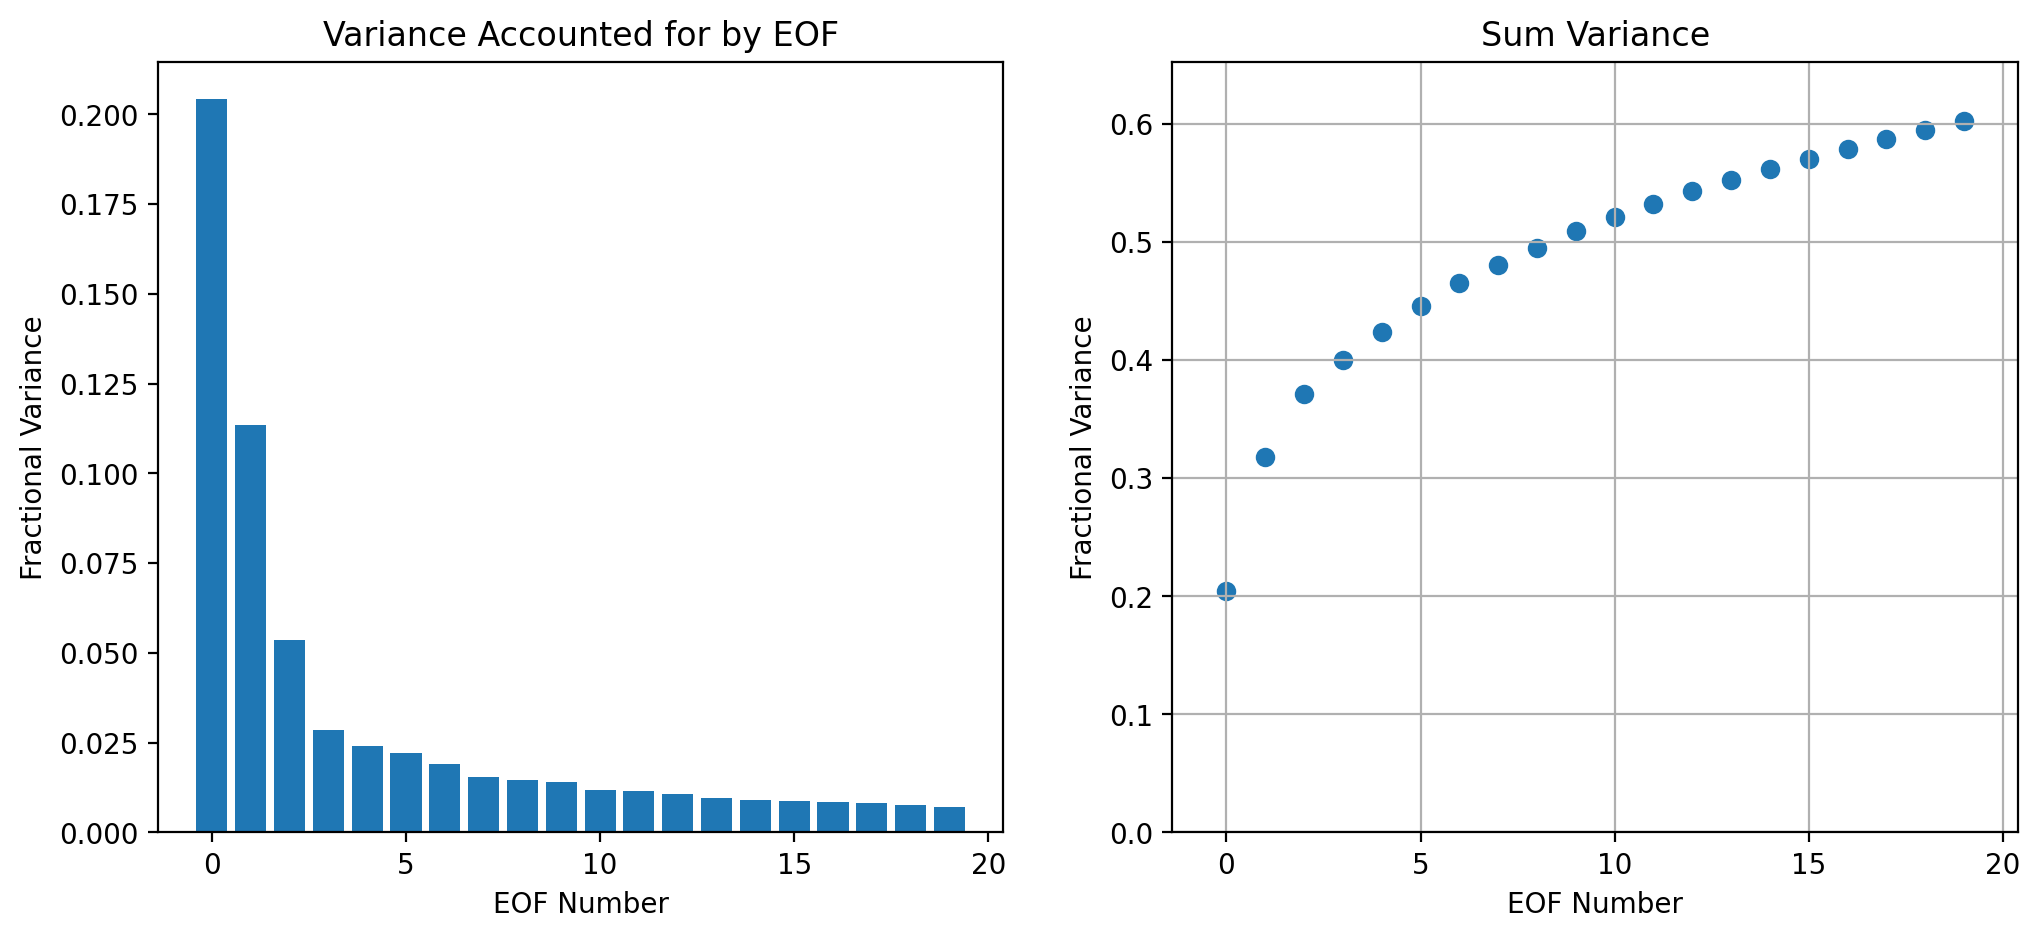

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Number of eofs to plot
num_eofs = 20
# Calculating the variance from each eof
variance = eigs[0:num_eofs]/eigs.sum()
# Calculating the sum of variance for first n eofs
sum_var = np.zeros(variance.shape)
sum_var[0] = variance[0]
# Summing
for i in range(1, len(variance)):
    sum_var[i] = sum_var[i-1] + variance[i]
# Plotting
ax1.bar(np.arange(num_eofs), variance)
ax2.scatter(np.arange(num_eofs), sum_var)

# Formatting params
ax1.set_title('Variance Accounted for by EOF')
ax1.set_xlabel('EOF Number')
ax1.set_ylabel('Fractional Variance')
ax1.set_xticks(np.arange(0, num_eofs+1, 5))

ax2.set_ylim([0, max(sum_var + 0.05)])
ax2.set_title('Sum Variance')
ax2.set_xlabel('EOF Number')
ax2.set_ylabel('Fractional Variance')
ax2.grid()

plt.show()

The first EOF should look like ENSO, so let's check:

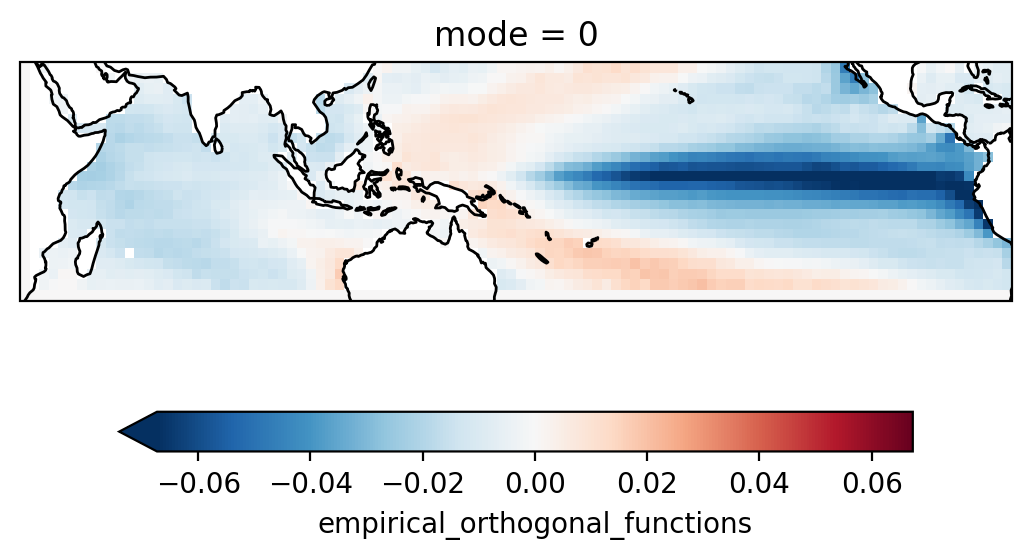

In [7]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=160, min_latitude=-45, max_latitude=45)))

eofs.isel(mode=0).plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8},
    robust=True,
)
ax.coastlines()

plt.show()

The first PC should also look like ENSO's record, so let's plot that too:

In [9]:
# Number of eofs to hold on to
num_eofs_to_keep = 15
# Getting projection of data in EOF space
proj = solver.projectField(dataset['anom'], neofs=num_eofs_to_keep)

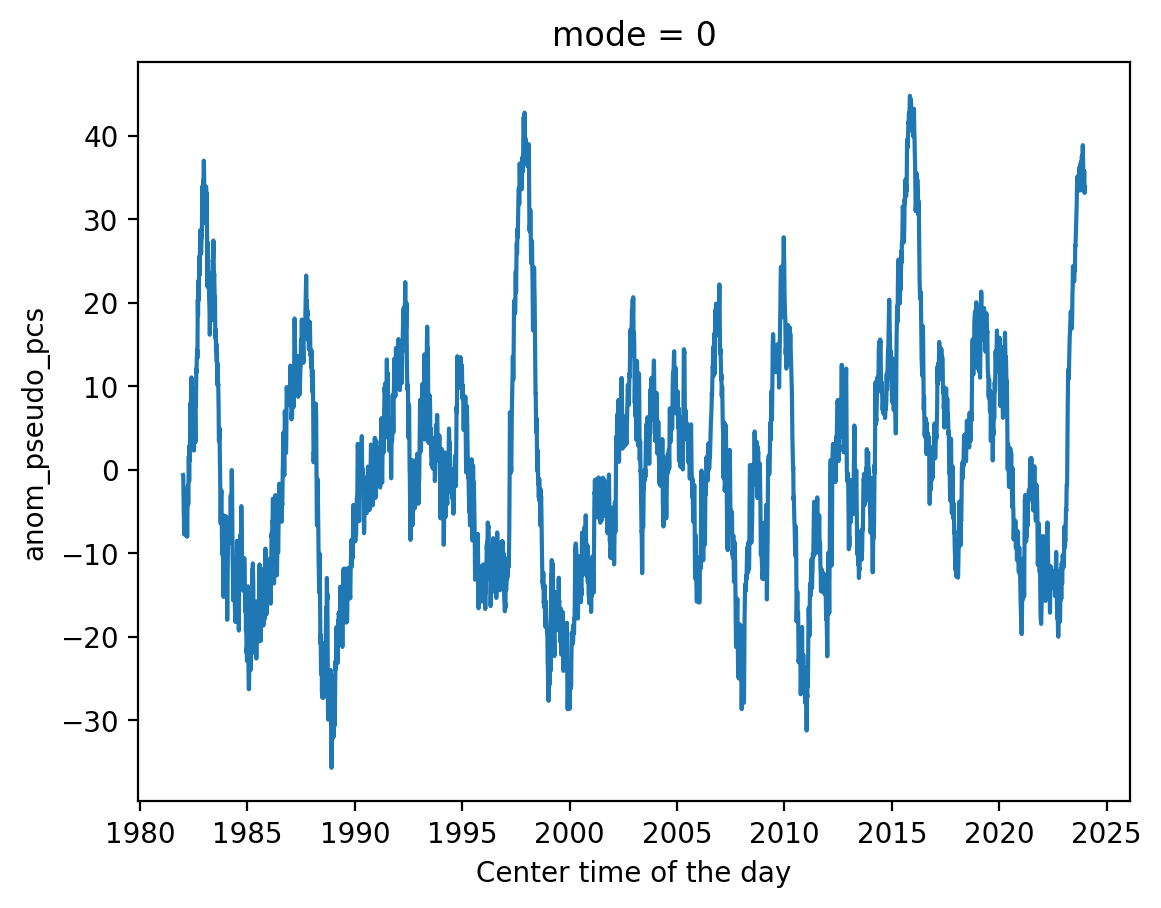

In [10]:
# Plotting first pc, should look like ENSO
(-proj.isel(mode=0)).plot();

# Calculating L
We can now choose some subset of the EOFs to keep. From here, we can calculate the system matrix $\textbf{L}$ as:
$$
\textbf{L} = \tau_0^{-1} \ln \left\{ \textbf{C}_{\tau_0} \textbf{C}_0^{-1} \right\}
$$
where
$$
\textbf{C}_0 = \left<\vec{x}(t) \vec{x}^T(t) \right>
$$
$$
\textbf{C}_{\tau_0} = \left<\vec{x}(t+\tau_0) \vec{x}^T(t) \right>
$$
are the covariance and lagged covariance matrices, respectively. The system matrix should be independent of choice of $\tau_0$, but we will see there are some potential sampling issues that cause the error to balloon.

### Empirical Normal Modes
The ENMs are solutions to the homogenous equation
$$
\frac{d\vec{x}}{dt} = \textbf{L}\vec{x}
$$
and have the general form $c_j \vec{u}_j \exp(\beta_j t)$, where $\vec{u}_j$ are the complex eigenvectors of $\textbf{L}$, $\beta_j$ are the corresponding complex eigenvalues, and $c_j$ is a complex amplitude. We can compose real solutions using complex conjugate pairs of eigenvectors and their eigenvalues, and choose $c_j$ such that:
$$
\vec{x}_j = \left\{\vec{a}_j\cos(\omega_j t) + \vec{b}_j\sin(\omega_j t) \right\}\exp(\sigma_j t)
$$
where $\sigma_j$ and $\omega_j$ are the real and imaginary part of $\beta_j$, respectively, and $\vec{a}_j$ and $\vec{b}_j$ are two real vectors satisfying the conditions $\vec{a}_j\cdot\vec{b}_j = 0$, $\vec{a}_j\cdot\vec{a}_j=1$, and $\vec{b}\cdot\vec{b} \geq 1$ (Penland & Sardeshmukh, 1995). We can then plot $e$-folding time vs. frequency, which we will do after this analysis.

In [11]:
# Calculates system matrix L for a given tau_0
# data is time series projected onto eof space
# tau_0 is the time lag to use to calculate L
def calc_L(data, tau_0):
    # Allocating memory for covariance matrices
    cov = np.zeros((num_eofs_to_keep, num_eofs_to_keep))
    lag_cov = np.zeros((num_eofs_to_keep, num_eofs_to_keep))
    # Calculating covariance matrix
    for vec in data:
        # Calculating covariance and adding to cov
        cov += np.outer(vec, vec)
    # Calculating lagged covariance matrix
    for lagged_vec, current_vec in zip(data[tau_0:], data[:-tau_0]):
        # Calculating lagged covariance and adding to lag_cov
        lag_cov += np.outer(lagged_vec, current_vec)
    # Normalizing
    cov = cov / len(data['time'])
    lag_cov = lag_cov / len(data[tau_0:]['time'])
    return (1/tau_0) * lg.logm(np.matmul(lag_cov, lg.inv(cov)))

In [12]:
%%time
# Time lag
tau_0 = 5
# Calculating L
L = calc_L(proj, tau_0)

CPU times: user 3.51 s, sys: 6.85 ms, total: 3.52 s
Wall time: 3.52 s


In [73]:
# Getting eigenvectors and eigenvalues
# Note: The ith eigenvector is evecs[:,i] not evecs[i]!
evals, evecs = lg.eig(L)

In [74]:
# Creating new array, removing complex congugate pair
no_repeat_evals = []
# Looping through evals
for val in evals:
    # If value is real...
    if np.imag(val) == 0:
        # Append to list
        no_repeat_evals.append(val)
    # Otherwise, if value is complex...
    else:
        # If the complex conjugate is not already in list...
        if not np.conjugate(val) in no_repeat_evals:
            # Append to our list
            no_repeat_evals.append(val)
# Making no_repeat_evals a numpy array
no_repeat_evals = np.array(no_repeat_evals)
# print list
print(no_repeat_evals)

[-0.02372027+0.01057049j -0.00351887+0.0010934j  -0.01158049+0.00895804j
 -0.00925469+0.00428102j -0.01919308+0.0055157j  -0.02279521+0.j
 -0.02094531+0.j         -0.01950043+0.j         -0.01222775+0.00159623j]


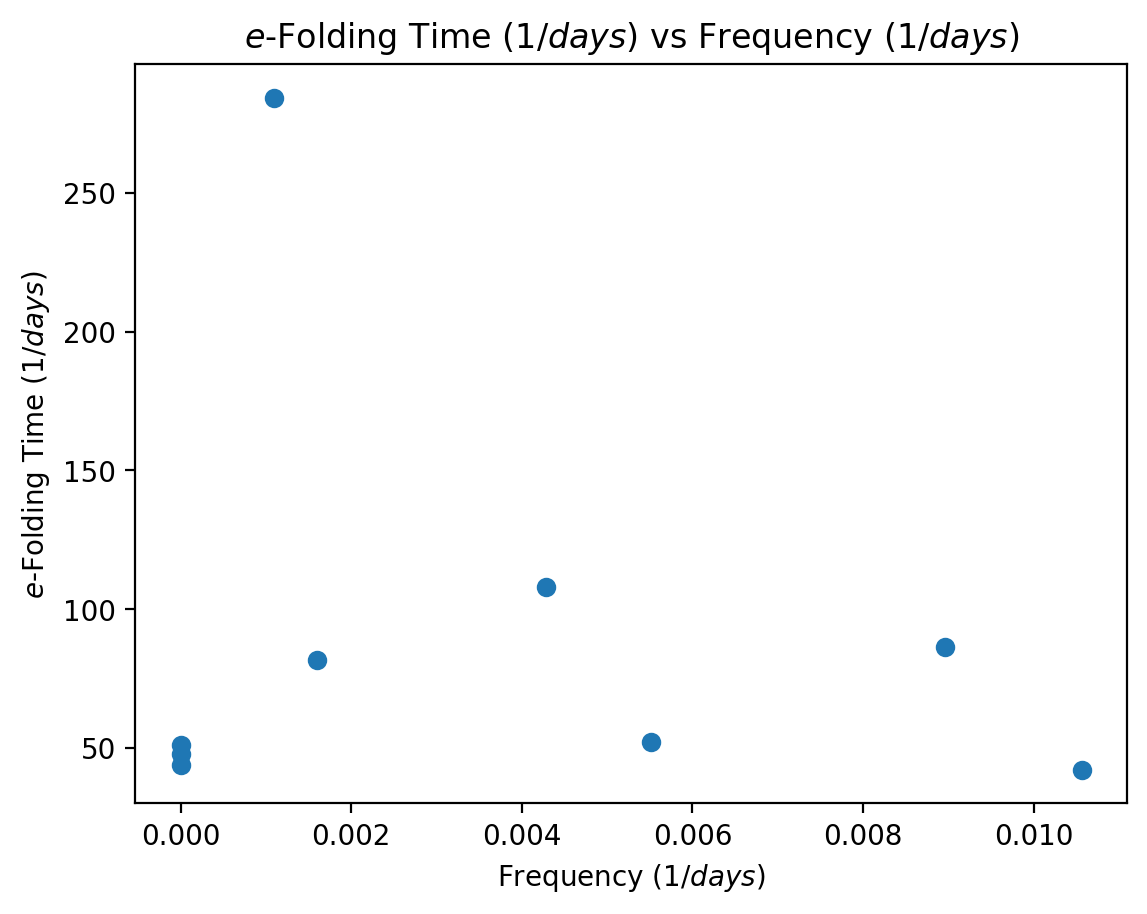

In [75]:
# Plot e-folding time vs frequency
# Calculating e-folding time
efolding = -1/np.real(no_repeat_evals)
# Getting frequency
freq = np.imag(no_repeat_evals)
# Plotting
fig, ax = plt.subplots(1, 1)

# Formatting
ax.set_title("$e$-Folding Time ($1/days$) vs Frequency ($1/days$)")
ax.set_xlabel("Frequency ($1/days$)")
ax.set_ylabel("$e$-Folding Time ($1/days$)")

ax.scatter(freq, efolding);

# Optimal Growth
We can define the "energy" as
$$
E_j(t) = \vec{x}_j(t) \cdot \vec{x}_j(t)
$$
The sum of $E_j$ gives us the total energy $E$. The growth parameter $\mu(t)$ is given by
$$
\mu(\tau) = \frac{E(\tau)}{E(0)} = \frac{\vec{x}(\tau)\cdot\vec{x}(\tau)}{\vec{x}(0)\cdot\vec{x}(0)}
$$
$$
= \frac{\vec{x}(0)\textbf{G}^T\textbf{G}(\tau)\vec{x}(0)}{\vec{x}(0)\cdot\vec{x}(0)}
$$
$\mu(\tau)$ is largest when $\vec{x}(t)$ points along the first eigenvector, $\vec{\phi}_1$, of $\textbf{G}^T\textbf{G}(\tau)$. In fact, $\mu(\tau)$ is given by the eigenvalue $\gamma_1$. We can plot the maximum growth as a function of $\tau$ by just plotting $\gamma_1(\tau)$.

In [16]:
# Creating a function to calculate G
# tau is a float, representing a time in days
# L is the system matrix
def G(tau, L):
    return lg.expm(L * tau)

In [160]:
# Ending time
tf = 150
# Number of days between datapoints
n = 5
# List of times to calculate optimal growth
times = np.arange(0, tf, n)
# To store max eigenvalue
growth =np.zeros_like(times, dtype='float')
# Calculating eigenvales for G at time t
for i, t in enumerate(times):
    # Calculating G transpose G
    propagator = np.matmul(G(t, L).transpose(), G(t, L))
    # Calculating eigenvalues
    prop_evals, prop_evecs = lg.eig(propagator)
    # Getting largest eigenvalue
    growth[i] = max(np.real(prop_evals))

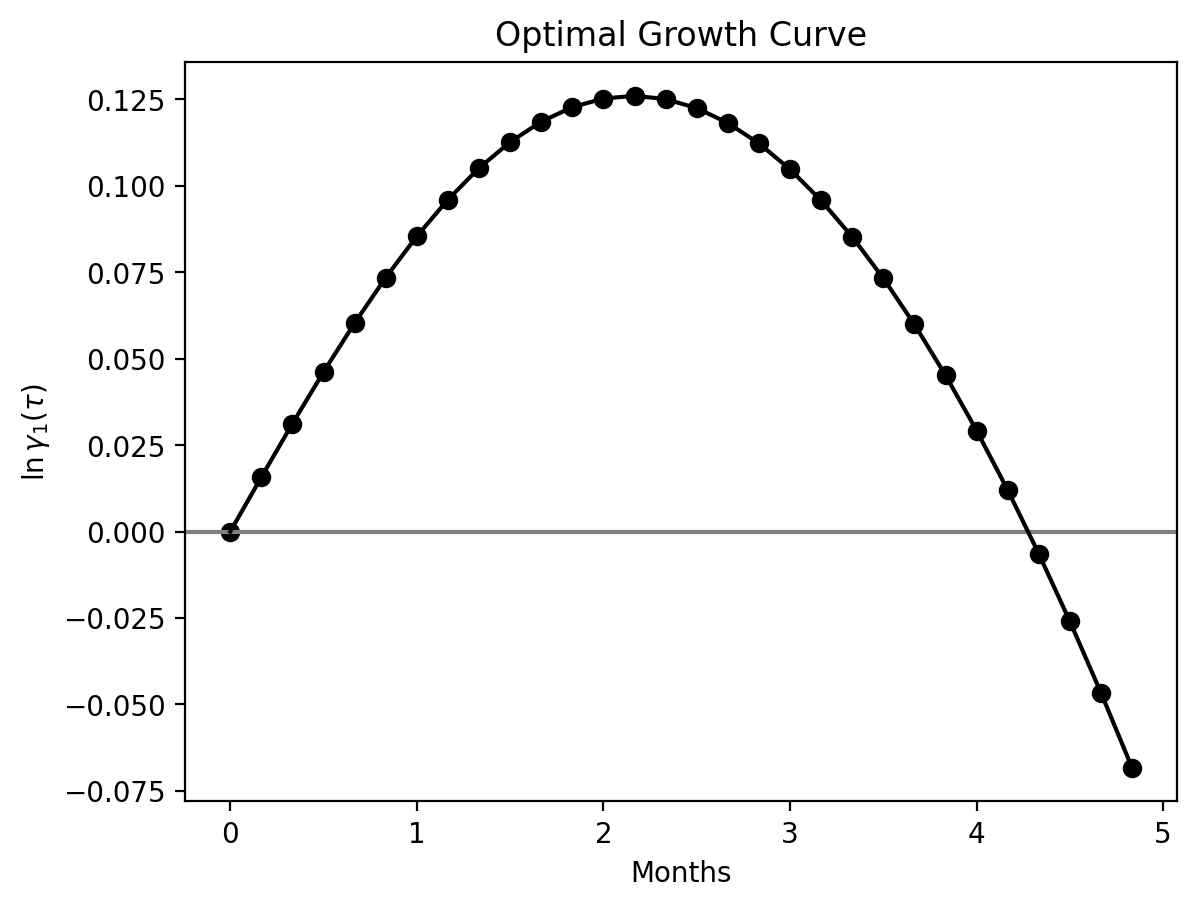

In [161]:
fig, ax = plt.subplots(1, 1)

# Setting figure title and axis labels
ax.set_title("Optimal Growth Curve")
ax.set_ylabel(r"$\ln\gamma_1(\tau)$")
ax.set_xlabel("Months")

# Setting x ticks to months
xticks = np.arange(0, tf+1, 30)
ticklabels = np.arange(0, len(xticks), 1)
ax.set_xticks(xticks)
ax.set_xticklabels(ticklabels)

# Drawing zero line
ax.axhline(0, 0, 1, c='gray')

# Plotting data
ax.plot(times, np.log(growth), 'k');
ax.scatter(times, np.log(growth), c='k');